# Intermezzo: Sparsely Observed Data

In the post on <a href="other_use_for_PCA_part2.html">using PCA for data imputation</a> we used a weight for each of our data points. By assigning a weight of 0 to missing data and a weight of 1 to the rest of our data we managed to be able to get a reasonably good approximation to what we would find using PCA on the dataset without any data missing. 

This is fine when evaluating a dense model for our data matrix is not too much computational overhead. However when our input data are sparsely observed, that is to say most of our data consists of missing values then evaluating the model densely is a tremendous waste of computational resources. <!-- TEASER_END -->
 Note that sparsely observed data and sparse data are not necessarily the same thing. It is possible for data to be sparse but to be densely observed. For example Word count vectors in bag of words models tend to be extremely sparse but the zeros in the count matrix are meaningful they mean that a particular term didn't appear. Therefore the zeros in a word count vector are observed zeros and so word count vectors are "densely observed" even though the data is sparse.

With sparsely observed data the large majority of entries in our data matrix represent unknown values. For example sports data consisting of pairings of teams and wins/losses most teams will not have been paired with most others in a given season making the data sparsely observd. Likewise in reccomender systems most users will not have ever rated or even seen most items and so most pairings of users and items represent unkown values. We could encode these data sets in sparse matrices but the entries outside of the data footprint don't really represent true observed zero's as in the word count case but rather just unknown values.

If we store such sparsely observed data as a sparse matrix any linear algebra routines that use these sparse matrices will treat values not in the footprint of the matrix as 0's, which is often the wrong thing to do for sparsely observed data. For example a team x team matrix of win/loss data could be encoded with +1 for wins and -1 for losses. A zero in such a matrix may be implicitly indicative of rough equality. But frequently team pairings are correlated with the strength of the teams. That means that it would not be unusual for the best team in the league to never play the worst team in the league. Because they never play we would end up putting a 0 in our win/loss matrix implicitly giving a weak signal of equality and messing up our analysis.

Normally the values that are stored in a sparse matrix are all the non-zero entries but here we instead will want to store only the observed entries of the matrix including zeros. For example if we were analyzing a large dataset of chess matches a natural way to represent a player/player pairing matrix might be to add a -1 for a loss a +1 for a win and a 0 for a draw. Most players will not play most others and so our pairing matrix will be sparsely observed. Moreover if all of two players games resulted in draws we would want to put an observed 0 in the data matrix at the location corresponding to those two players. Because most matches between very good players result draws throwing these draws away simply because they are "zero" entries would be a waste. Therefore from now on in this post we will not talk about the "non-zero" part of a matrix but rather its "observed footprint". 

If we don't take into account the fact that values outside of our sparse matrix footprint (call it the observation footprint) are not actually 0 but rather represent unknown values then we will end up with inferior results. If we can afford to evaluate a dense model matrix then we can deal with missing observations by applying a 0 weight to them in our fits. But, if our input data is very large and very sparsely observed say for example a ratings matrix with perhaps millions of rows representing users and millions of columns representing items we cannot even afford to store the dense model matrix in memory.

Since the values of our model at points with zero data weight don't affect our parameter updates at all why not simply never evalute them in the first place? We can adapt our previous weighted PCA method to work in a sparse manner simply by getting rid of the data weights all together and letting the non-zero footprint of a sparse input matrix determine where to evaluate the data model and/or accumulate our parameter updates.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import scipy.ndimage
import sklearn
import sklearn.datasets
import sklearn.decomposition

In [2]:
%matplotlib inline

plt.rcParams.update(
    {
        "figure.figsize":(10,6),
        "font.size":16,
        "image.cmap":"afmhot",
        "image.interpolation":"nearest",
        "image.aspect":"auto",
    }
)

#make a custom orange/blue divergent color map which goes through black at 0
#it just feels more natural to represent 0 as black.
from matplotlib.colors import LinearSegmentedColormap
clist = [(1.0, 0.5, 0.0), (0.0, 0.0, 0.0), (0.0, 0.5, 1.0)]
blue_orange_divergent = LinearSegmentedColormap.from_list("BuOrDiv", clist)

We will use the scipy.sparse.coo_matrix format to store and pass around our sparse data. The coo format stores a sparse matrix as a vector of values and a corresponding vector of row indexes and column indexes which indicate where in the data matrix each value would go. Since the matrix is sparse storing these three vectors is much more efficient than storing just one dense 2D array of values. 

Our data may be sparse but we are actually fitting a dense model and we will still want to keep representations of W and H as dense 2D arrays. Unfortunately the product WH is now just too large to explicitly compute as a dense array. Instead we need a helper function which will compute the value of WH at precise locations which match the observed footprint of our data (or later the footprint of predictions we wish to make).

In [3]:
def partial_outer_product(
    w, #(nrows, rank)
    h_t, #(ncols, rank)
    row_indexes, 
    col_indexes, 
    output_format="raw",
):
    """
    Evaluates the product wh on a small footprint of matrix locations corresponding to the row/column pairs
    passed indicated by the row_indexes and col_indexes arguments.
    """
    #find the weights corresponding to each row and the basis vector values corresponding to each column
    wvals = w[row_indexes]
    hvals = h_t[col_indexes]
    
    #calcualate w and h as arrays and sum over ranks to find the corresponding dense matrix values
    result = np.sum(wvals*hvals, axis=1)
    
    #most of the time we will not want to convert back to sparse matrix format so just return the result as a vector
    if output_format == "raw":
        pass
    elif output_format == "coo":
        # just in case we want the data back as a sparse matrix. 
        #Note this matrix is not really WH but rather just the entries evaluated at the input rows/cols
        result = scipy.sparse.coo_matrix((result, (row_indexes, col_indexes)))
    else:
        raise NotImplementedError("don't know how to return output format = {}".format(output_format))
    
    return result

Because we can no longer simply sum along an axis of a 2D array to get a sum over rows or a sum over columns we will also need a helper function to do these sums for us. A little python code snippet to do just that given a numpy array of values and arrays of the corresponding row (or column) indexes is easily written but not very fast of course since it requires a python for loop. We can speed things up by wrapping that code in a numba jit decorator which turns the python function into a wrapper for a much faster C code. 

In [4]:
from numba import jit

@jit
def sum_into_vector(values, indexes, n_out):
    out = np.zeros(n_out)
    for i in range(len(indexes)):
        ci = indexes[i]
        out[ci] =  out[ci] + values[i]
    return out


## PCA the usual way.

There are a couple of nuances that I just smoothed over in the data imputation blog post and that require more careful attention here. In order to make it clear what is going on we should first take a moment to sketch out what is going on in PCA in the densely observed case. PCA can be thought of as being equivalent to finding the least squares solution to approximating our data matrix $X$ with a low rank matrix product $\hat{X} = WH$ where W is a N by K coefficient matrix (the "weights") and H is K by M (where m is the number of features of our data) matrix of basis vectors (the "principal vectors"). For the rest of the discussion here we will just assume that $X$ has already been mean subtracted so that the column averages are 0.

There is some freedom in how to choose W and H such that they optimally well solve the least squares approximation problem but it can be shown that if you pick H so that it's rows are the K eigenvectors greatest eigenvalue of the data covariance matrix and W as the corresponding decomposition of the rows of X into the eigenbasis H no other solution can do better in terms of least squares error. 

By the properties of eigenvectors it is always possible to find an eigenbasis in which the eigenvectors are orthonormal. The orthonormality of these eigenvectors means that $H^TH=I_K$ where $I_K$ is the K by K identity matrix. The optimal W matrix can be calculated by a simple matrix product $W = X~H^T$. If H were a complete basis of the data space that is if K=M then $WH = X~H^TH = X~I = X$. This is by no means a proof that for K < M that the approximation is optimal but it is possible to show with a little linear algebra. The key is to first consider just one vector $v$ and to show that for a single vector you can't do better than the choice of the eigenvector of $\frac{1}{N}X^TX$ of largest eigenvalue. With that result in hand the rest follows since you can project out the first eigenvector from your data point cloud and repeat the process K times. 

If your data doesn't have too many columns then one solution to finding the optimal W and H is to first compute the data covariance matrix $\Sigma = \frac{1}{N}X^TX$ (again this assumes that X is mean subtracted). Then find the K largest eigenvectors of $\Sigma$ which become H and finally leverage the orthonormality of $H$ to calculate the optimal weights as $W=X~H^T$. However this won't work if you have hundreds of thousands of columns and really because of poor numerical conditioning it won't even work very well for even just 100 features or so. It turns out that you can get around the problem of poor numerical conditioning by never explicitly calculating the covariance matrix and instead directly finding the <a href="https://en.wikipedia.org/wiki/Singular-value_decomposition"> singular value decomposition </a> of the data matrix. There are even implementations of the singular value decomposition for sparse matrices in scipy.sparse.linalg and so if your data is simply sparse instead of sparsely observed then that is problem solved right there. 

## Why the usual way isn't good enough

When we move from densely observed data to sparsely observed data we can't just use singular value decomposition because the singular vectors we find will be poor approximations of the underlying correlation structure. For small perturbations to our data (e.g. small additive white noise) the eigenvectors come out OK. However multiplying most of the entries in our data matrix by 0 can hardly beconsidered a small perturbation and the resultant eigenvectors or singular vectors can't be trusted.

Just as troublesome is the fact that we won't be able to count on the orthonormality of our basis vectors any more.
A lot of the convenience of the eigen/singular vector approach comes directly from the fact that we can pick H to be orthonormal. If H is orthonormal then essentially $H^T=H^{-1}$ because $H^TH=I_K$. Technically $H^T$ isn't really the inverse of H but what is called a <a href="https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse">pseudo-inverse</a>. With orthonormality on our side the optimal weights are calculated simply via a matrix multiplication $W = X~H^T$. Although it is still possible for us to choose an orthonormal basis when we consider all features together the orthonormality won't hold on random subsets of the features. Let $H_i$ be the basis vectors evaluated for only the features which are available for row i of our data set. For each row we need to solve the linear problem $X_i \approx w_i~H_i$. 


## Toy Dataset

Lets make a toy data set which we know can be represented exactly as a low rank system WH. The "rank" of the system is the number of columns in W and the number of rows in H. The rank is the number of independent "factors" which go into calculating an entry in the dense data matrix.

In [5]:
npts_row = 150
n_col = 120
rank = 3

w_true = np.random.normal(size=(npts_row, rank))
h_true = np.random.normal(size=(rank, n_col))

#make the dense low rank data
x_dense = np.dot(w_true, h_true)

kept_frac = 0.2

obs_mask = np.random.random(x_dense.shape) < kept_frac

#dense matrix of sparsely observed data
x_obs_dense = x_dense*obs_mask

#sparse matrix of sparsely observed data
x_obs_sparse = scipy.sparse.coo_matrix(x_obs_dense)

x_obs_sparse

<150x120 sparse matrix of type '<class 'numpy.float64'>'
	with 3603 stored elements in COOrdinate format>

In [6]:
def small_model_comparison_plot(
    dense_truth,
    sparse_observations,
    dense_model,
    cmap_percentile=15,
    cmap=None,
):
    fig, axes = plt.subplots(2, 2)
    axes = axes.ravel()
    
    vmin, vmax = np.percentile(dense_truth, [cmap_percentile, 100-cmap_percentile])
    im_kwargs = {"cmap":cmap, "vmin":vmin, "vmax":vmax}
    
    ax = axes[0]
    ax.imshow(dense_truth, **im_kwargs)
    ax.set_title("Dense Ground Truth", fontsize=16)

    ax=axes[1]
    ax.imshow(sparse_observations.todense(), **im_kwargs)
    ax.set_title("Sparse Observations", fontsize=16)

    ax=axes[2]
    ax.imshow(dense_model, **im_kwargs)
    ax.set_title("Dense Reconstruction", fontsize=16)

    ax=axes[3]
    ax.imshow(dense_truth-dense_model, **im_kwargs)
    ax.set_title("Residuals")

    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

## PCA without accounting for missing data

First lets proceed as we would if there was no missing data and just do pca on the dense data matrix with the missing data filled in with zeros. Note that the true data mean is 0 and so this would be the equivalent of doing PCA on a mean imputed data set.

In [7]:
#Do PCA via singular value decomposition
u, s, v = np.linalg.svd(x_obs_dense, full_matrices=False)
w_dumb = (u*s)[:, :rank]
h_dumb = v[:rank]

#build the dense model
dumb_model = np.dot(w_dumb, h_dumb)


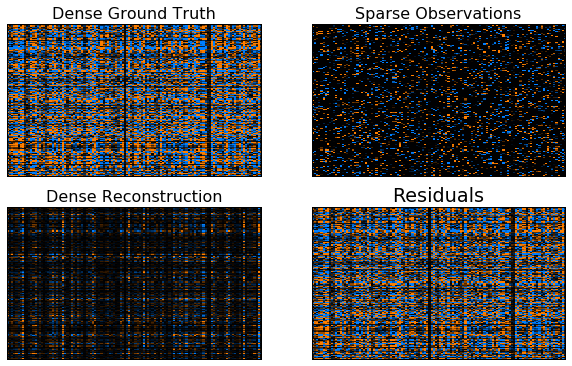

In [8]:
small_model_comparison_plot(
    dense_truth=x_dense,
    sparse_observations=x_obs_sparse,
    dense_model=dumb_model,
    cmap=blue_orange_divergent,
)

In [9]:
def rms(x):
    return np.sqrt(np.mean(x**2))

In [10]:
rms(x_dense-dumb_model)/rms(x_dense)

0.81993969045522008

Because the singular value decomposition is treating all those missing data values as real zeros the PCA expansion works hard to predict 0 for all the missing data. Since most of the data is missing we end up with the result that our model and residual plots look reversed! Our model of our data is mostly zeros and as a result the residuals to the true data which was mostly non-zero is of large magnitude.

## PCA on randomly observed footprints

One solution is to solve the system with weighted least squares where we only penalize for residuals on the observed footprint of our data $X_F$.

$$
\chi^2 = \sum_{i,j \in X_F} \left( X_{i,j} - \sum_{l=1}^K W_{il}H_{lj} \right)^2
$$

using the scipy coo sparse matrix the sum over the matrix footprint $X_F$ amounts to summing over the stored row and column index pairs. Likewise instead of carrying out an explicit matrix product between W and H we can easily evaluate the model for just exactly that row/column pair by finding the appropriate row in W and the column in H and then just doing a dense multiply followed by a sum over rank. Simultaneously optimizing for all of the coefficients in both of W and H sounds hard so lets not do it.

Instead lets pick a sub problem which is easy enough that we can find the solution in closed form. Lets first focus on finding the optimal weights $W_{i,l}$ for a single component number $l$ leaving all the other coefficients fixed.
At first lets just assume that all the other weight components are 0 so that we can just drop the other terms from our equation. Evaluating the derivative of our equation above and setting it equal to zero we can get the closed form solution below;

$$
W_{i, l} = \frac{\sum_{i,j \in X_F} X_{i,j} H_{lj} }{ \sum_{i,j \in X_F} H_{lj}^2}
$$

That is nice but clearly we can do better if we don't let all the other components be zero. We can adapt this solution to solve for all the components simply by iterating over the components one at a time and instead of attempting to predict the data $X_{i,j}$ directly we try to predict the residuals to the current model $\delta X_{i,j} = X_{i,j} - \sum W_{il}H_{lj}$ and then update our weight vector with the results of that calculation.

$$
\delta W_{i, l} = \frac{\sum_{i,j \in X_F} \delta X_{i,j} H_{lj} }{ \sum_{i,j \in X_F} H_{lj}^2}
$$

What about fitting for $H_{i,j}$? Well if you look at the expression for $\chi^2$ again you will notice that the expression is actually symmetric with respect to W and H but with the roles of row and column reversed. Therefore we can just use the same closed form solution that we got for updates to W to calculate updates for H but replacing W with H and i with j.

There is a detail here which I have somewhat smoothed over. Namely if the row vectors of $H$ are strongly coupled on the data footprint (that is to say if $\sum_{i,j \in X_F} H_{lj}H_{mj}$ is large for a given l and m then the updates to W can become divergent (the same thing of course is true of updates to H if an analogous term for W is too large). To deal with this problem there are 2 things we can do to help, the simplest one is to just add a small damping term to our updates so that they are always just a tiny bit smaller than you would expect from the formula above this will keep us from diverging too much too rapidly. The more important step though is to also periodically orthogonalize the basis vectors $H_{l,j}$ so that the average dot product between the basis vectors is 0. The random observation footprint of our data means that this orthogonality is only approximate for any given observation footprint but since we are averaging over a large number of rows the orthogonality should still hold on average and therefore our updates should be nicely decoupled. 

This orthogonalization can be done via singular value decomposition on our basis vectors. Note that this is a much smaller problem than doing SVD on the whole data set since we are only using a matrix which is of a size the number of features of our input data matrix times the rank of our model.

Lets translate this procedure into code and see what happens!

In [11]:
class SparselyObservedLowRankApproximation(object):
    W = None   #weight matrix
    H_t = None #transpose of H matrix
    mean = None #column wise data mean
    
    def __init__(
        self,
        rank,
        max_iter=100,
        convergence_delta=1e-5,
        orthogonalize_freq=5,
        mean_subtract=True,
        H_damp=1e-3,
        W_damp=1e-5,
        verbose=False,
    ):
        #convert the input matrix to coordinate format
        self.rank = rank
        self.H_damp = H_damp
        self.W_damp = W_damp
        self.max_iter = max_iter
        self.convergence_delta=convergence_delta
        self.orthogonalize_freq=orthogonalize_freq
        self.mean_subtract = mean_subtract
        self.verbose = verbose
    
    def fit(self, x):
        #convert to coordinate sparse matrix format
        x = x.tocoo()
        
        n_rows, n_cols = x.shape
        
        #initialize the coefficients
        if self.W is None:
            W = np.zeros((x.shape[0], self.rank))
            self.W = W
        if self.H_t is None:
            H_t = np.random.normal(size=(x.shape[1], self.rank))
            H_t /= np.sqrt(np.sum(H_t**2, axis=0))
            self.H_t = H_t
        if self.mean is None:
            #sum up the value in each column
            column_sum = sum_into_vector(values=x.data, indexes=x.col, n_out=n_cols)
            #count the number of entries in each column
            counts = sum_into_vector(values=np.ones(len(x.data)), indexes=x.col, n_out=n_cols)
            mean = column_sum/counts
            self.mean = mean
        
        target = x.data
        if self.mean_subtract:
            target = target - self.mean[x.col]
        
        last_err = np.sqrt(np.mean(target**2))
        for iter_idx in range(self.max_iter):
            if self.verbose:
                print("iteration", iter_idx+1)
            ortho = iter_idx % self.orthogonalize_freq == 0
            self.iterate(
                x,
                pre_orthogonalize=ortho,
            )
            mod = partial_outer_product(self.W, self.H_t, row_indexes=x.row, col_indexes=x.col)
            cur_resids = target - mod
            cur_err = np.sqrt(np.mean(cur_resids**2))
            if self.verbose:
                print("Residual RMS {:4.5f}".format(cur_err))
            if cur_err > last_err - self.convergence_delta:
                break
            
    
    def estimate_W(
        self, 
        x, 
        component_index=None,
        H_t=None,
        W_start=None, 
        W_damp=None,
        copy_W=True,
    ):
        """
        Estimate the decomposition of the observed part of x as a linear combination of the basis vectors H_t.
        """
        n_rows, n_cols = x.shape
        
        if W_damp is None:
            W_damp = self.W_damp
        
        if W_start is None:
            W_start = np.zeros((x.shape[0], self.rank))
        
        if copy_W:
            W = W_start.copy()
        else:
            W = W_start
        
        if H_t is None:
            H_t = self.H_t
        
        row_indexes = x.row
        col_indexes = x.col
                
        target = x.data
        if self.mean_subtract:
            target = x.data - self.mean[col_indexes]
        
        if component_index is None:
            component_indexes = range(self.rank)
        else:
            component_indexes = [component_index]
        
        #evaluate the model on our footprint
        mod = partial_outer_product(W, H_t, row_indexes=row_indexes, col_indexes=col_indexes)
        cur_resids = target - mod
        
        for comp_idx in component_indexes:
            csub_h = H_t[col_indexes, comp_idx]
            raw_prod = cur_resids*csub_h
            prod = sum_into_vector(values=raw_prod, indexes=row_indexes, n_out=n_rows)
            w_denom = sum_into_vector(values=csub_h**2, indexes=row_indexes, n_out=n_rows)
            w_delt = prod/(w_denom+W_damp)
            W[:, comp_idx] += w_delt
            #adjust the residuals to take into account the change in coefficients
            cur_resids -= csub_h*w_delt[row_indexes]
        
        return W
    
    def estimate_H_t(
        self,
        x,
        W,
        component_index=None,
        H_t_start=None, 
        H_damp=None,
        copy_H=True,
    ):
        """Estimate the basis vectors from their weight vectors"""
        n_rows, n_cols = x.shape
        
        if H_damp is None:
            H_damp = self.H_damp
        
        if H_t_start is None:
            H_t_start = self.H_t
        
        H_t = H_t_start
        if copy_H:
            H_t = H_t.copy()
                
        row_indexes = x.row
        col_indexes = x.col
        
        target = x.data
        if self.mean_subtract:
            target = x.data - self.mean[col_indexes]
        
        if component_index is None:
            component_indexes = range(self.rank)
        else:
            component_indexes = [component_index]
        
        #evaluate the model on our footprint
        mod = partial_outer_product(W, H_t, row_indexes=row_indexes, col_indexes=col_indexes)
        cur_resids = target - mod
        
        for comp_idx in component_indexes:            
            csub_w = W[row_indexes, comp_idx]
            raw_prod = cur_resids*csub_w
            prod = sum_into_vector(values=raw_prod, indexes=col_indexes, n_out=n_cols)
            h_denom = sum_into_vector(values=csub_w**2, indexes=col_indexes, n_out=n_cols)
            h_delt = prod/(h_denom + H_damp)
            H_t[:, comp_idx] += h_delt
            cur_resids -= csub_w*h_delt[col_indexes]
        
        return H_t
        
    def orthogonalize_basis(
        self,
    ):  
        H_t = self.H_t
        W = self.W
        
        h_norm = np.sqrt(np.sum(H_t**2, axis=0))
        H_t = H_t/h_norm
        W = W*h_norm
            
        #scale each row of H by its captured variance to preserve variance ordering
        column_scale = np.std(W, axis=0)+1e-5
        column_scale /= np.sum(column_scale)
        H_scaled = H_t*column_scale
            
        H_t_old = H_t
            
        #orthogonalize principal vectors
        H_t = np.linalg.svd(H_scaled.transpose(), full_matrices=False)[2].transpose()    
            
        #rotate weights onto the new basis
        old_vector_decomposition = np.dot(H_t_old.transpose(), H_t)
        rot_mat = old_vector_decomposition
        W = np.dot(W, rot_mat)
            
        #permute W and H to order by variance largest first
        permute = np.argsort(-np.std(W, axis=0))
        H_t = H_t[:, permute]
        W = W[:, permute]
            
        self.H_t = H_t
        self.W = W
    
    
    def iterate(
        self, 
        x,
        pre_orthogonalize=False,
    ):        
        if pre_orthogonalize:
            self.orthogonalize_basis()
      
        H_t = self.H_t
        W = self.W
        
        W = self.estimate_W(
            x,
            W_start=W,
            copy_W=False,
        )
            
        H_t = self.estimate_H_t(
            x,
            W=W,
            H_t_start=H_t,
            copy_H=False,
        )
        
        #keep the principal vectors normalized
        h_norm = np.sqrt(np.sum(H_t**2, axis=0))
        H_t = H_t/h_norm
        W = W*h_norm
        
        self.W = W
        self.H_t = H_t
        
        
    def transform(self, x):
        """transform a data matrix into a weight matrix"""
        return self.estimate_W(
            x, 
            W_start=np.zeros((x.shape[0], self.rank)),
            copy_W=False
        )

# Sparse Observations Handled Right

Lets return to the toy low rank data set and see what happens when we apply our new missing data aware algorithm.

In [12]:
#fit a model to the sparse observations using only sparse model evaluations 
slra = SparselyObservedLowRankApproximation(
    rank=rank, 
    orthogonalize_freq=2,
    max_iter=20, 
    mean_subtract=False
)
slra.fit(x_obs_sparse)

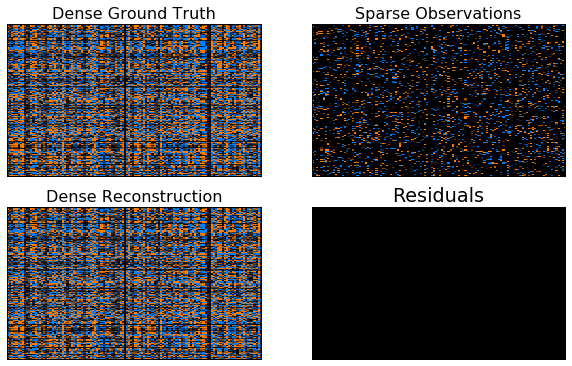

In [13]:
smart_model = np.dot(slra.W, slra.H_t.transpose())

small_model_comparison_plot(
    dense_truth=x_dense,
    sparse_observations=x_obs_sparse,
    dense_model=smart_model,
    cmap=blue_orange_divergent,
)

In [14]:
resids = x_dense - smart_model
np.std(resids)/np.std(x_dense)

2.6349742762600857e-05

Now that our model is ignoring all the missing data we are able to perfectly capture the structure of the toy model data. That is nice but since this data was designed to be suceptible to exactly this sort of analysis we shouldn't get too excited yet. 

Lets take our new algorithm out for a spin on some real data. The face data we used in the last post seems like a good pick. This time though lets occlude the majority of each face instead of just a small portion.

In [15]:
faces_ds = sklearn.datasets.fetch_olivetti_faces()

faces = faces_ds["data"]
#divide by the global standard deviation
faces /= np.std(faces)

subject_ids = faces_ds["target"]

im_shape = (64, 64)

def as_image(arr):
    return arr.reshape(im_shape)
    
def view_as_image(arr, ax=None, **imshow_kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    ax.axis("off")
    im = ax.imshow(as_image(arr), **imshow_kwargs)
    return im

In [16]:
np.random.seed(1234)

occlusion_fraction = 0.8

hole_scale = 0.5
#generate random uncorrelated noise
occlusion_mask = np.random.normal(size=[len(faces)] + list(im_shape))

#Smooth the noise locally to make the noise fluctuations change only on several pixel scale
occlusion_mask = scipy.ndimage.filters.gaussian_filter(occlusion_mask, hole_scale)
occlusion_mask = occlusion_mask > np.percentile(occlusion_mask, 100*occlusion_fraction)
#flatten to match face data shape

occlusion_mask = occlusion_mask.reshape((len(faces), -1))

occluded_faces = faces*occlusion_mask

In [17]:
sparse_faces = scipy.sparse.coo_matrix(occluded_faces)

sparse_faces

<400x4096 sparse matrix of type '<class 'numpy.float32'>'
	with 327679 stored elements in COOrdinate format>

In [18]:
slra_faces = SparselyObservedLowRankApproximation(
    rank=20, 
    orthogonalize_freq=3,
    max_iter=50,
    H_damp=1e-5,
    W_damp=1e-5,
    mean_subtract=True,
)
slra_faces.fit(sparse_faces, )

faces_model_smart = np.dot(slra_faces.W, slra_faces.H_t.transpose()) + slra_faces.mean

Lets also fit a regular PCA expansion on the data just for comparison. Since it is very easy to find the column average only over the non-missing data we will give the regular PCA expansion the benefit of the doubt and use the average only over the observations.

If you don't do this then the regular PCA expansion bears almost no resemblance to the underlying data and isn't even recognizable as a face.

In [19]:
#fit a regular non-missing data aware PCA expansion for comparison

mean_face = slra_faces.mean
deltas = (faces-mean_face)*occlusion_mask
u, s, v = np.linalg.svd(deltas, full_matrices=False)
w_faces_dumb = (u*s)[:, :slra_faces.rank]
h_faces_dumb = v[:slra_faces.rank]

faces_model_dumb = np.dot(w_faces_dumb, h_faces_dumb) + mean_face

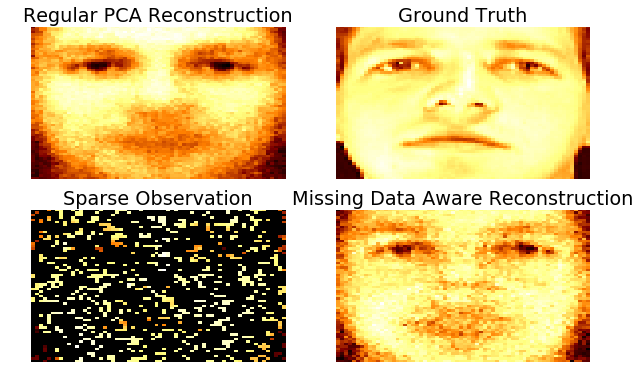

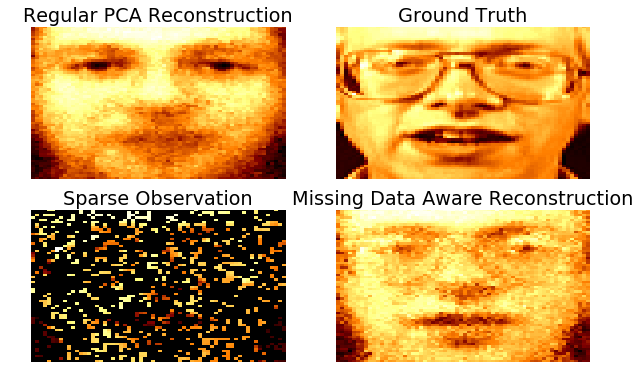

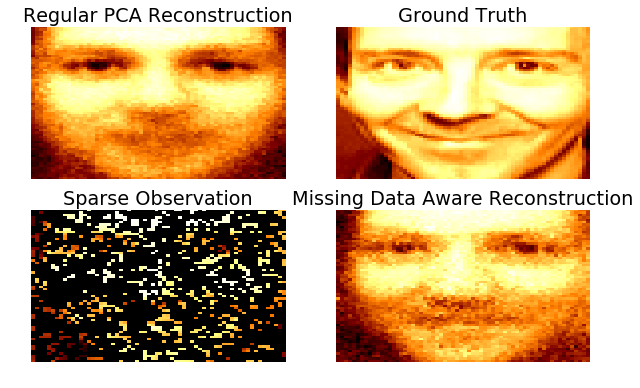

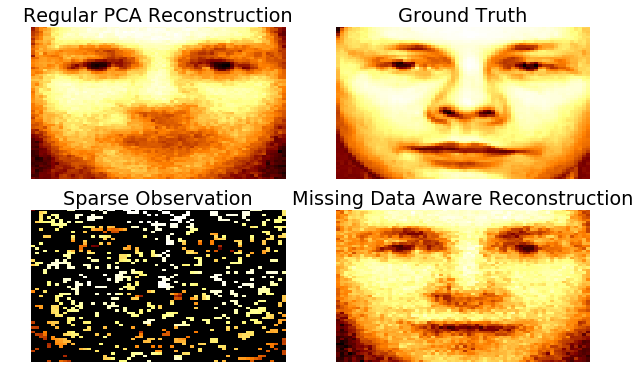

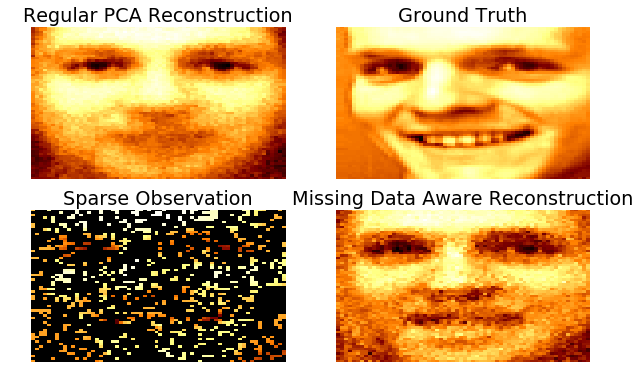

In [20]:
for example_index in [6, 16, 26, 36, 46]:
    fig, axes = plt.subplots(2, 2)
    axes = axes.ravel()
    
    ax = axes[0]
    view_as_image(faces_model_dumb[example_index], ax=ax)
    ax.set_title("Regular PCA Reconstruction")

    ax = axes[1]
    view_as_image(faces[example_index], ax=ax)
    ax.set_title("Ground Truth")

    ax = axes[2]
    view_as_image(occluded_faces[example_index], ax=ax)
    ax.set_title("Sparse Observation")

    ax = axes[3]
    view_as_image(faces_model_smart[example_index], ax=ax)
    ax.set_title("Missing Data Aware Reconstruction")
    
    plt.show()


The results are somewhat noisy but considering that each input datum is not even recognizable as a face the results seem pretty good to me. This is especially true when you compare the results to what happens when you carry out PCA the usual way without accounting for the fact that 0's are not meaningful. Again since the sparsely observed data matrix is mostly zeros the PCA reconstruction ends up being dominated by the mean face and there isn't much variation. Also what variation there is isn't as closely matched to the underlying structure of the data and so we don't get very good models. 

The visual comparison suggests that our missing data aware algorithm is significantly out performing a vanilla SVD based pca expansion, numerically how much smaller are the typical model residuals? 

In [21]:
rms(faces - faces_model_dumb), rms(faces-faces_model_smart)

(0.70762500062305911, 0.4911178629537471)

The difference in the magnitudes of each models reconstruction error is not nearly so striking as it was for the toy model. That is because the underlying face data doesn't admit a good very low rank approximation, this data is intrinsically high dimensional. How much better could we have possibly done? Lets cheat and use regular PCA to find the optimal low rank approximation to all the data at once with no occlusion.

In [22]:
mean_face = np.mean(faces, axis=0)
deltas = faces-mean_face
u, s, v = np.linalg.svd(deltas, full_matrices=False)
w_faces_cheats = (u*s)[:, :slra_faces.rank]
h_faces_cheats = v[:slra_faces.rank]

faces_model_cheats= np.dot(w_faces_cheats, h_faces_cheats) + mean_face

In [23]:
rms(faces-faces_model_cheats)

0.39140856

Using the same number of model components the best we could only have done slightly better (0.39 instead of 0.49 RMS). Note that because we occluded 80% of each face the cheating model is getting the benefit of 5 times as much face data as was available to the missing data aware model. Also the cheating model RMS error will be a slight underestimate since the model fit procedure got to see all of the data including the data it was ultimately evaluated on.

Remember sparsely observed data and sparse data aren't the same!